In [1]:
# Import libraries
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from roformer import RoFormerConfig, RoFormerForSequenceClassification
from tokenizer.my_tokenizers import SMILES_SPE_Tokenizer


from functions.data_funcs import reset_parameters
from functions.inference_funcs import find_checkpoint_with_lowest_val_mse

# Load data ######################################################################

def get_auto_tokenizer(model_name):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

def encode_data(data, tokenizer):
    encoded_data = []
    for i, row in data.iterrows():
        smiles = row['smiles']
        encoded = tokenizer(smiles, return_tensors='pt')
        encoded_data.append(encoded)
    return encoded_data

def get_auto_model(model_name):
    # Load model
    config = AutoConfig.from_pretrained(model_name, num_labels=1)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    model.config.problem_type = 'regression'
    # freeze model
    for param in model.parameters():
        param.requires_grad = False
    return model

def get_roformer_tokenizer():
    vocab_file = 'tokenizer/new_vocab.txt'
    splits_file = 'tokenizer/new_splits.txt'
    tokenizer = SMILES_SPE_Tokenizer(vocab_file, splits_file)
    return tokenizer

def get_roformer_model(tokenizer):
    config = RoFormerConfig(
        vocab_size=tokenizer.vocab_size,
        embedding_size=768,
        max_position_embeddings=768,
        num_hidden_layers=6,
        num_attention_heads=12,
        hidden_size=768,
        intermediate_size=3072,
        type_vocab_size=2,
        pad_token_id=tokenizer.pad_token_id,
        is_decoder=False,
        num_labels=1,
        hidden_dropout_prob=0,
        attention_probs_dropout_prob=0,
        problem_type='regression'
    )

    model = RoFormerForSequenceClassification(config=config)
    model = reset_parameters(model)
    model.cuda()
    # freeze model
    for param in model.parameters():
        param.requires_grad = False
    return model

def get_huggingface_model(model_name):
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.cuda()
    # freeze model
    for param in model.parameters():
        param.requires_grad = False
    return model

def predict_model(input_ids, attention_mask, model):
    import torch
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs

def get_predictions(encoded_data, model):
    # from tqdm import tqdm
    predictions = []
    # for encoded in tqdm(encoded_data):
    for encoded in encoded_data:
        input_ids = encoded['input_ids'].to('cuda')
        attention_mask = encoded['attention_mask'].to('cuda')
        outputs = predict_model(input_ids, attention_mask, model)
        predictions.append(outputs[0].item())
    return predictions

def get_model_predictions(holdout, model, encoded_data, ckpt_path):#, saving_label):
    validation_data = pd.read_csv(f'revision/training_data/clusters/cluster_{holdout + 1}.csv')
    validation_data.columns = ['smiles', 'label']
    classification_data = validation_data.copy()

    for i in range(5):
        kfold = i + 1
        checkpoint = find_checkpoint_with_lowest_val_mse(f"{ckpt_path}{kfold}/")
        checkpoint_data = torch.load(checkpoint, map_location='cuda')
        new_state_dict = OrderedDict()
        for k, v in checkpoint_data['state_dict'].items():
            name = k[6:]
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
        model.eval()
        # freeze model
        for param in model.parameters():
            param.requires_grad = False
        model.cuda()
        predictions = get_predictions(encoded_data, model)
        # append predictions to classification data
        classification_data[f'pred_{i+1}'] = predictions
    # save predictions
    classification_data['label_classification'] = classification_data['label'].apply(lambda x: 1 if x >= -5.5 else 0)
    classification_data['mean'] = classification_data[['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5' ]].mean(axis=1)
    # classification_data.to_csv(f'{saving_label}_allpreds.csv', index=False)
    return classification_data

def get_huggingface_predictions(holdout, model, encoded_data):
    validation_data = pd.read_csv(f'revision/training_data/clusters/cluster_{holdout}.csv')
    validation_data.columns = ['smiles', 'label']

    classification_data = validation_data.copy()
    predictions = get_predictions(encoded_data, model)
    classification_data['pred'] = predictions
    classification_data['label_classification'] = classification_data['label'].apply(lambda x: 1 if x >= -5.5 else 0)
    return classification_data

# Function to darken colors
def darken_color(color, amount=0.8):
    c = np.array(color)
    return np.clip(c * amount, 0, 1)

# make plot
def plot_roc_auc(data, saving_label):
    # Create a custom colormap
    oldcmp = plt.get_cmap('Set2')
    newcmp = ListedColormap(oldcmp.colors[:6])
    # Extract the colors from the colormap and darken them
    dark_colors = [darken_color(color) for color in newcmp.colors]
    
    # colors = ['red', 'darkorange', 'green', 'blue', 'purple']
    plt.figure()
    for i in range(5):
        fpr, tpr, thresholds = roc_curve(data['label_classification'], data[f'pred_{i+1}'])
        roc_auc = roc_auc_score(data['label_classification'], data[f'pred_{i+1}'])
        plt.plot(fpr, tpr, color=dark_colors[i], lw=1.5, linestyle='-', label=f'ROC fold {i+1} (AUC = {roc_auc:.3f})')
    
    fpr, tpr, thresholds = roc_curve(data['label_classification'], data['mean'])
    roc_auc = roc_auc_score(data['label_classification'], data['mean'])
    
    mean_fpr = fpr
    mean_tpr = tpr
    mean_auc = roc_auc
    
    plt.plot(fpr, tpr, color='black', lw=2, label=f'ROC mean (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=1.2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    # plt.savefig(f'{saving_label}_roc-auc.svg', format='svg')
    return mean_fpr, mean_tpr, mean_auc


from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# make plot
def plot_pr_auc(data, saving_label):

    # Create a custom colormap
    oldcmp = plt.get_cmap('Set2')
    newcmp = ListedColormap(oldcmp.colors[:6])
    # Extract the colors from the colormap and darken them
    dark_colors = [darken_color(color) for color in newcmp.colors]
    
    plt.figure()
    for i in range(5):
        precision, recall, thresholds = precision_recall_curve(data['label_classification'], data[f'pred_{i+1}'])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, color=dark_colors[i], lw=1.5, linestyle='-', label=f'PR fold {i+1} (AUC = {pr_auc:.3f})')
    
    precision, recall, thresholds = precision_recall_curve(data['label_classification'], data['mean'])
    pr_auc = auc(recall, precision)
    
    mean_precision = precision
    mean_recall = recall
    mean_prauc = pr_auc
    
    
    plt.plot(recall, precision, color='black', lw=2, label=f'PR mean (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower left")
    plt.title('Precision-Recall AUC')
    plt.grid(True)
    # plt.savefig(f'{saving_label}_pr-auc.svg', format='svg')
    plt.show()
    
    return mean_precision, mean_recall, mean_prauc


/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Holdout 1


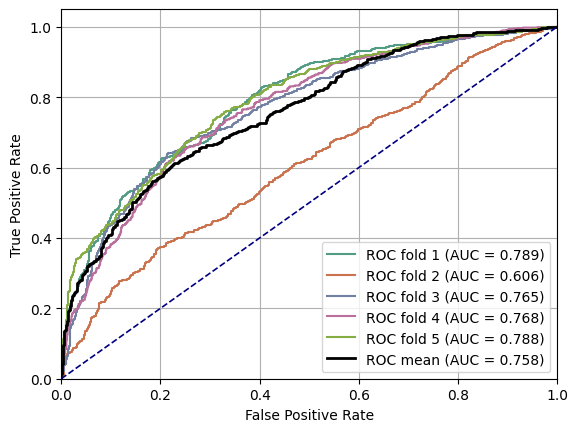

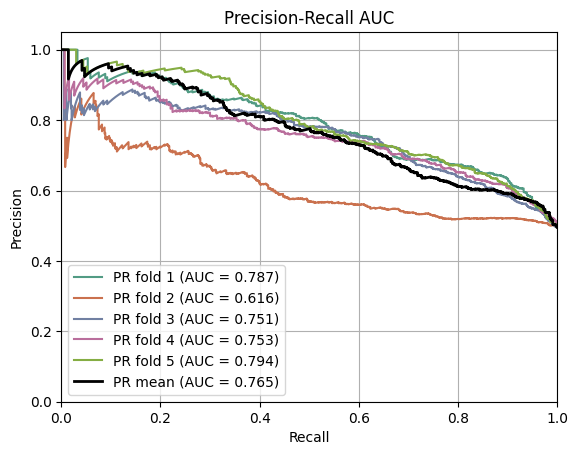

Holdout 2


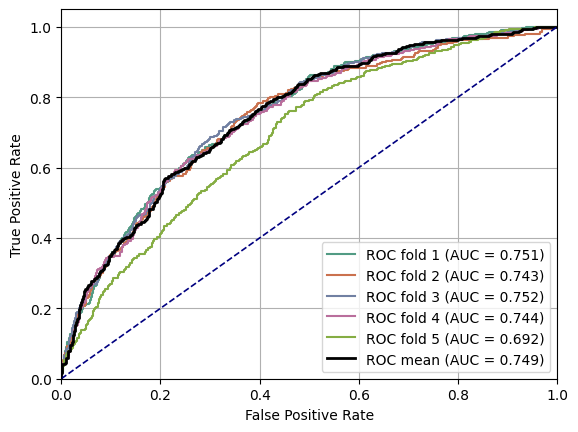

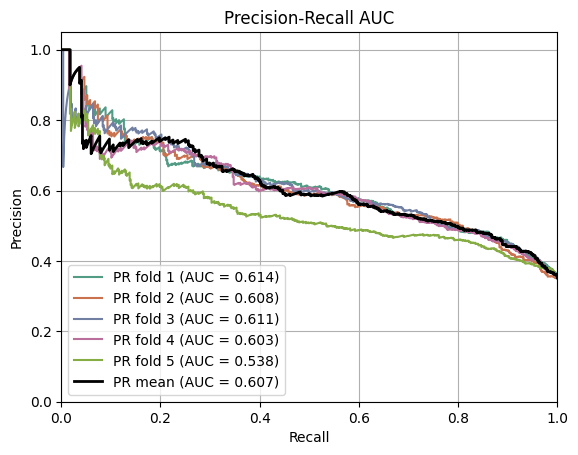

Holdout 3


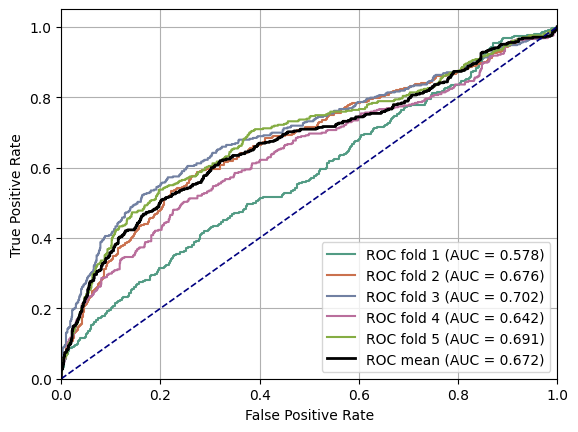

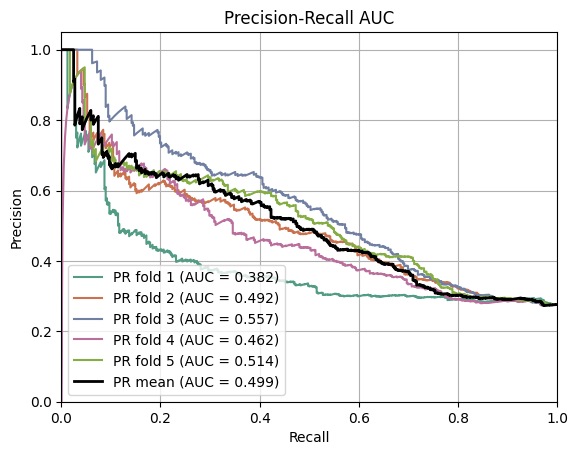

Holdout 4


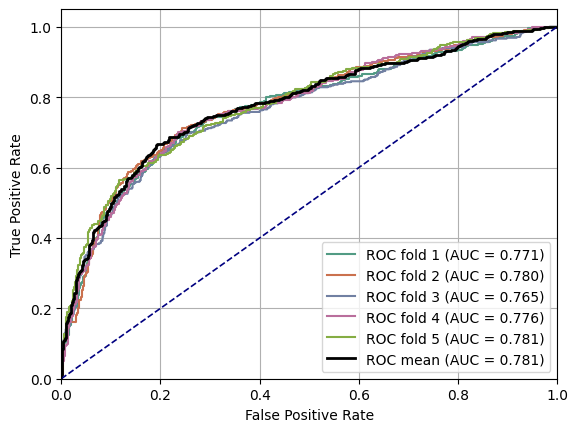

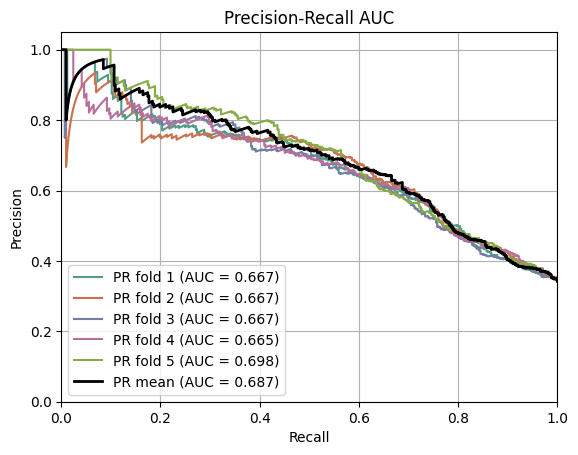

Holdout 5


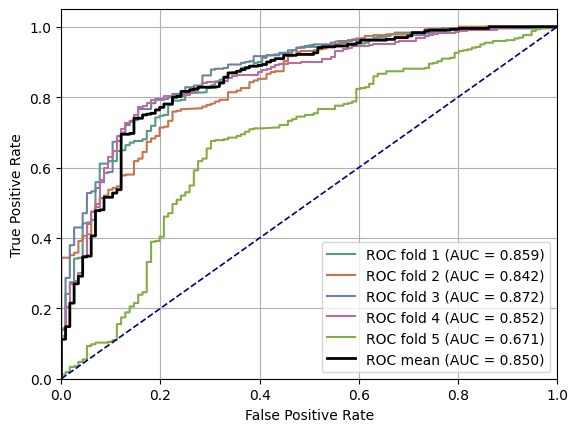

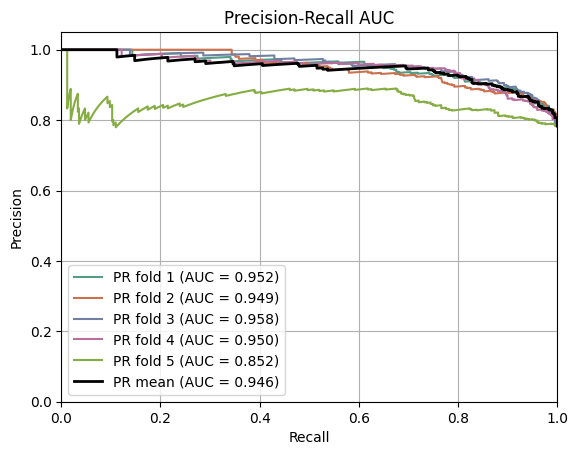

Holdout 6


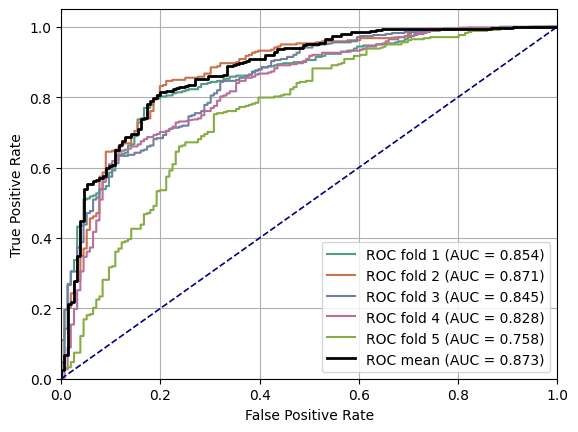

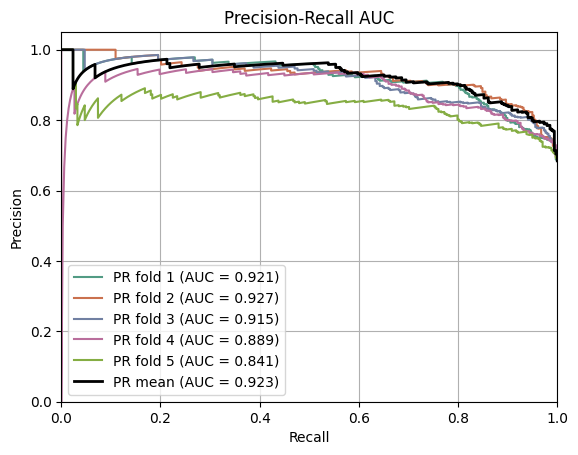

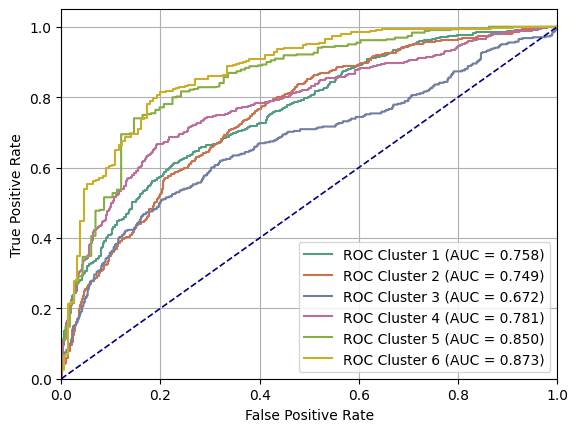

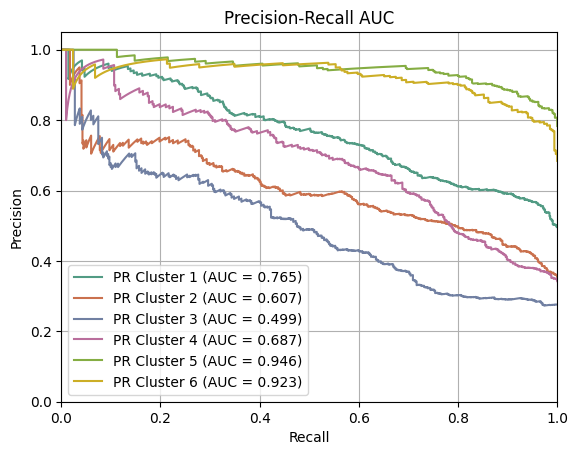

In [5]:
# Plot AUROC and PR AUC
from sklearn.metrics import mean_squared_error

### FOR FULL PeptideLM Model ###
auroc_values = []
pr_auc_values = []
rmse_values = []

# save mean values for each holdout
mean_fprs = []
mean_tprs = []
mean_aucs = []
mean_precisions = []
mean_recalls = []
mean_praucs = []

for i in range(6):
    print(f'Holdout {i+1}')
    ckpt_path = f'checkpoints/2024-11-14_PepLM-peptide_and_sm_testHoldoutCluster{i+1}_Kfold'

    input_data = pd.read_csv(f'revision/training_data/clusters/cluster_{i+1}.csv')
    input_data.columns = ['smiles', 'label']
    validation_data = input_data.copy()

    # Load tokenizer
    tokenizer = get_roformer_tokenizer()
    # Encode data
    encoded_data = encode_data(validation_data, tokenizer)
    # Load model
    model = get_roformer_model(tokenizer)
    # Load checkpoints and evaluate
    classification_data = get_model_predictions(i, model, encoded_data, ckpt_path)#, saving_label)
    
    # Plot ROC curve
    mean_fpr, mean_trp, mean_auc = plot_roc_auc(classification_data, f'figures/PepLM-peptide_and_sm_interaction_{i+1}')
    mean_precision, mean_recall, mean_prauc = plot_pr_auc(classification_data, f'figures/PepLM-peptide_and_sm_interaction_{i+1}')
    
    mean_fprs.append(mean_fpr)
    mean_tprs.append(mean_trp)
    mean_aucs.append(mean_auc)
    mean_precisions.append(mean_precision)
    mean_recalls.append(mean_recall)
    mean_praucs.append(mean_prauc)

# Create a custom colormap
oldcmp = plt.get_cmap('Set2')
newcmp = ListedColormap(oldcmp.colors[:6])
# Extract the colors from the colormap and darken them
dark_colors = [darken_color(color) for color in newcmp.colors]

# plot all 
plt.figure()
for i in range(6):
    plt.plot(mean_fprs[i], mean_tprs[i], lw=1.5, linestyle='-', label=f'ROC Cluster {i+1} (AUC = {mean_aucs[i]:.3f})', color=dark_colors[i])
# # plot average line
# mean_fpr = np.mean(mean_fprs, axis=0)
# mean_tpr = np.mean(mean_tprs, axis=0)
# mean_auc = np.mean(mean_aucs)
# plt.plot(mean_fpr, mean_tpr, color='black', lw=2, label=f'ROC mean (AUC = {mean_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
# plt.show()
plt.savefig(f'revision/figures/PepLM-full-AUROC.svg', format='svg')

# plot PR AUC
plt.figure()
for i in range(6):
    plt.plot(mean_recalls[i], mean_precisions[i], lw=1.5, linestyle='-', label=f'PR Cluster {i+1} (AUC = {mean_praucs[i]:.3f})', color=dark_colors[i])
# # plot average line
# mean_precision = np.mean(mean_precisions, axis=0)
# mean_recall = np.mean(mean_recalls, axis=0)
# mean_prauc = np.mean(mean_praucs)
# plt.plot(mean_recall, mean_precision, color='black', lw=2, label=f'PR mean (AUC = {mean_prauc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.title('Precision-Recall AUC')
plt.grid(True)
# plt.show()
plt.savefig(f'revision/figures/PepLM-full-PR-ROC.svg', format='svg')



In [22]:
# FULL PeptideCLM Model
from sklearn.metrics import mean_squared_error

models = ['full', 'peptide', 'sm']

for model_name in models:
    print(f'Model: {model_name}')
    RMSE_values = []
    auroc_values = []
    pr_auc_values = []

    for i in range(6):
        if model_name == 'full':
            ckpt_path = f'checkpoints/2024-11-14_PepLM-peptide_and_sm_testHoldoutCluster{i+1}_Kfold'
        elif model_name == 'peptide':
            ckpt_path = f'checkpoints/2024-11-14_PepLM-peptide_only_testHoldoutCluster{i+1}_Kfold'
        elif model_name == 'sm':
            ckpt_path = f'checkpoints/2024-11-14_PepLM-sm_only_testHoldoutCluster{i+1}_Kfold'

        input_data = pd.read_csv(f'revision/training_data/clusters/cluster_{i+1}.csv')
        input_data.columns = ['smiles', 'label']
        validation_data = input_data.copy()

        # Load tokenizer
        tokenizer = get_roformer_tokenizer()
        # Encode data
        encoded_data = encode_data(validation_data, tokenizer)
        # Load model
        model = get_roformer_model(tokenizer)
        # Load checkpoints and evaluate
        predicted_data = get_model_predictions(i, model, encoded_data, ckpt_path)#, saving_label)

        # calculate RMSE value
        rmse_value = mean_squared_error(predicted_data['label'], predicted_data['mean'], squared=False)
        RMSE_values.append(rmse_value)
        
        # calculate AUROC value
        auroc = roc_auc_score(predicted_data['label_classification'], predicted_data['mean'])
        auroc_values.append(auroc)

        # calculate PR AUC
        precision, recall, _ = precision_recall_curve(predicted_data['label_classification'], predicted_data['mean'])
        pr_auc = auc(recall, precision)
        pr_auc_values.append(pr_auc)
        
    # calculate mean RMSE value and standard deviation
    mean_rmse = sum(RMSE_values) / len(RMSE_values)
    std_rmse = (sum([(rmse - mean_rmse) ** 2 for rmse in RMSE_values]) / len(RMSE_values)) ** 0.5
    print(f'Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}')

    # calculate mean AUROC value and standard deviation
    mean_auroc = sum(auroc_values) / len(auroc_values)
    std_auroc = (sum([(auroc - mean_auroc) ** 2 for auroc in auroc_values]) / len(auroc_values)) ** 0.5
    print(f'Mean AUROC: {mean_auroc:.4f} +/- {std_auroc:.4f}')

    mean_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
    std_pr_auc = (sum([(pr_auc - mean_pr_auc) ** 2 for pr_auc in pr_auc_values]) / len(pr_auc_values)) ** 0.5
    print(f'Mean PR AUC: {mean_pr_auc:.4f} +/- {std_pr_auc:.4f}')
    

Model: full
Mean RMSE: 0.7419 +/- 0.2142
Mean AUROC: 0.7805 +/- 0.0667
Mean PR AUC: 0.7378 +/- 0.1609
Model: peptide
Mean RMSE: 0.7233 +/- 0.1745
Mean AUROC: 0.7728 +/- 0.0841
Mean PR AUC: 0.7323 +/- 0.1678
Model: sm
Mean RMSE: 0.8391 +/- 0.2633
Mean AUROC: 0.7702 +/- 0.0579
Mean PR AUC: 0.7251 +/- 0.1659


In [2]:
# Random-init Model
from sklearn.metrics import mean_squared_error

auroc_values = []
pr_auc_values = []
RMSE_values = []

for i in range(6):
    ckpt_path = f'checkpoints/2024-11-14_PepLM_RandomInit_holdOutCluster_{i+1}_fold'

    input_data = pd.read_csv(f'revision/training_data/clusters/cluster_{i+1}.csv')
    input_data.columns = ['smiles', 'label']
    validation_data = input_data.copy()

    # Load tokenizer
    tokenizer = get_roformer_tokenizer()

    # Encode data
    encoded_data = encode_data(validation_data, tokenizer)

    # Load model
    model = get_roformer_model(tokenizer)

    # Load checkpoints and evaluate
    predicted_data = get_model_predictions(i, model, encoded_data, ckpt_path)#, saving_label)

    rmse_value = mean_squared_error(predicted_data['label'], predicted_data['mean'], squared=False)
    RMSE_values.append(rmse_value)

    auroc = roc_auc_score(predicted_data['label_classification'], predicted_data['mean'])
    auroc_values.append(auroc)

    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(predicted_data['label_classification'], predicted_data['mean'])
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)


# calculate mean RMSE value and standard deviation
mean_rmse = sum(RMSE_values) / len(RMSE_values)
std_rmse = (sum([(rmse - mean_rmse) ** 2 for rmse in RMSE_values]) / len(RMSE_values)) ** 0.5
print(f'Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}')

# calculate mean AUROC value and standard deviation
mean_auroc = sum(auroc_values) / len(auroc_values)
std_auroc = (sum([(auroc - mean_auroc) ** 2 for auroc in auroc_values]) / len(auroc_values)) ** 0.5
print(f'Mean AUROC: {mean_auroc:.4f} +/- {std_auroc:.4f}')

mean_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
std_pr_auc = (sum([(pr_auc - mean_pr_auc) ** 2 for pr_auc in pr_auc_values]) / len(pr_auc_values)) ** 0.5
print(f'Mean PR AUC: {mean_pr_auc:.4f} +/- {std_pr_auc:.4f}')

Mean RMSE: 0.8190 +/- 0.1951
Mean AUROC: 0.6664 +/- 0.0662
Mean PR AUC: 0.6619 +/- 0.1345


ChemBERTa-2 MLM 5M

In [ ]:
# model_name = "DeepChem/ChemBERTa-5M-MLM"
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

model_precursor = "DeepChem/ChemBERTa-"

model_names = ["77M-MTR", 
               "10M-MTR", 
               "5M-MTR", 
               "77M-MLM", 
               "10M-MLM", 
               "5M-MLM"]

for model_params in model_names:
    model_name = model_precursor + model_params
    # Load tokenizer
    tokenizer = get_auto_tokenizer(model_name)
    # Load model
    model = get_auto_model(model_name)

    r2_values = []
    auroc_values = []
    pr_auc_values = []
    RMSE_values = []

    for i in range(6):
        validation_data = pd.read_csv(f'revision/training_data/clusters/cluster_{i+1}.csv')
        validation_data.columns = ['smiles', 'label']
        encoded_data = encode_data(validation_data, tokenizer)

        ckpt_path = f'checkpoints/2024-11-13_model_ChemBERTa-2_{model_params}_holdOutCluster_{i+1}_fold'

        # Load checkpoints and evaluate
        predicted_data = get_model_predictions(i, model, encoded_data, ckpt_path)#, saving_label)

        # # calculate R2 value
        # r2 = r2_score(classification_data['label'], classification_data['mean'])
        # r2_values.append(r2)
        
        rmse_value = mean_squared_error(predicted_data['label'], predicted_data['mean'], squared=False)
        RMSE_values.append(rmse_value)
        
        auroc = roc_auc_score(predicted_data['label_classification'], predicted_data['mean'])
        auroc_values.append(auroc)
        
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(predicted_data['label_classification'], predicted_data['mean'])
        pr_auc = auc(recall, precision)
        pr_auc_values.append(pr_auc)
    
    # calculate mean RMSE value and standard deviation
    mean_rmse = sum(RMSE_values) / len(RMSE_values)
    std_rmse = (sum([(rmse - mean_rmse) ** 2 for rmse in RMSE_values]) / len(RMSE_values)) ** 0.5
    print(f'Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}')

    # calculate mean AUROC value and standard deviation
    mean_auroc = sum(auroc_values) / len(auroc_values)
    std_auroc = (sum([(auroc - mean_auroc) ** 2 for auroc in auroc_values]) / len(auroc_values)) ** 0.5
    print(f'Mean AUROC: {mean_auroc:.4f} +/- {std_auroc:.4f}')

    mean_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
    std_pr_auc = (sum([(pr_auc - mean_pr_auc) ** 2 for pr_auc in pr_auc_values]) / len(pr_auc_values)) ** 0.5
    print(f'Mean PR AUC: {mean_pr_auc:.4f} +/- {std_pr_auc:.4f}')
    
    

/stor/work/Wilke_Fall2023/afeller/pepLM/amd_gpu/lib/python3.8/site-packages/torch/_utils.py:832: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7340 +/- 0.1417
Mean AUROC: 0.6922 +/- 0.0435
Mean PR AUC: 0.6619 +/- 0.1491


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7704 +/- 0.1404
Mean AUROC: 0.6917 +/- 0.0727
Mean PR AUC: 0.6695 +/- 0.1732


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7473 +/- 0.1424
Mean AUROC: 0.6846 +/- 0.0580
Mean PR AUC: 0.6675 +/- 0.1507


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-5M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7309 +/- 0.1274
Mean AUROC: 0.7343 +/- 0.0533
Mean PR AUC: 0.7015 +/- 0.1593


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7051 +/- 0.1439
Mean AUROC: 0.7286 +/- 0.0441
Mean PR AUC: 0.6902 +/- 0.1721


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7240 +/- 0.1337
Mean AUROC: 0.7425 +/- 0.0629
Mean PR AUC: 0.6963 +/- 0.1714


In [4]:
# ChemBERTa-1
from sklearn.metrics import r2_score

model_precursor = "seyonec/ChemBERTa-"

model_names = ["zinc-base-v1"]

for model_params in model_names:
    model_name = model_precursor + model_params
    # Load tokenizer
    tokenizer = get_auto_tokenizer(model_name)
    # Encode data
    encoded_data = encode_data(validation_data, tokenizer)
    # Load model
    model = get_auto_model(model_name)

    rmse_values = []
    auroc_values = []
    pr_auc_values = []

    for i in range(6):
        ckpt_path = f'checkpoints/2024-11-13_model_ChemBERTa-1_holdOutCluster_{i+1}_fold'
        
        validation_data = pd.read_csv(f'revision/training_data/clusters/cluster_{i+1}.csv')
        validation_data.columns = ['smiles', 'label']
        encoded_data = encode_data(validation_data, tokenizer)
        
        # Load checkpoints and evaluate
        predicted_data = get_model_predictions(i, model, encoded_data, ckpt_path)#, saving_label)

        # calculate R2 value
        rmse_value = mean_squared_error(predicted_data['label'], predicted_data['mean'], squared=False)
        rmse_values.append(rmse_value)
        
        auroc = roc_auc_score(predicted_data['label_classification'], predicted_data['mean'])
        auroc_values.append(auroc)
        
        # calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(predicted_data['label_classification'], predicted_data['mean'])
        pr_auc = auc(recall, precision)
        pr_auc_values.append(pr_auc)
    
    # calculate mean RMSE value and standard deviation
    mean_rmse = sum(rmse_values) / len(rmse_values)
    std_rmse = (sum([(rmse - mean_rmse) ** 2 for rmse in rmse_values]) / len(rmse_values)) ** 0.5
    print(f'Mean RMSE: {mean_rmse:.4f} +/- {std_rmse:.4f}')

    # calculate mean AUROC value and standard deviation
    mean_auroc = sum(auroc_values) / len(auroc_values)
    std_auroc = (sum([(auroc - mean_auroc) ** 2 for auroc in auroc_values]) / len(auroc_values)) ** 0.5
    print(f'Mean AUROC: {mean_auroc:.4f} +/- {std_auroc:.4f}')

    mean_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
    std_pr_auc = (sum([(pr_auc - mean_pr_auc) ** 2 for pr_auc in pr_auc_values]) / len(pr_auc_values)) ** 0.5
    print(f'Mean PR AUC: {mean_pr_auc:.4f} +/- {std_pr_auc:.4f}')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean RMSE: 0.7136 +/- 0.1465
Mean AUROC: 0.7010 +/- 0.0812
Mean PR AUC: 0.6697 +/- 0.1872
